In [93]:
import pandas as pd
import rdkit
from chembl_webresource_client.new_client import new_client
import numpy as np
from rdkit import Chem
from keras.models import Sequential
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from keras.layers import LeakyReLU
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect


In [21]:
df = pd.read_csv('test.csv')

In [22]:
act_normal = df[df.standard_value.notna()]
act_normal = act_normal[act_normal.canonical_smiles.notna()]
act_normal = act_normal.drop_duplicates(['canonical_smiles'])
act_normal

,Unnamed: 0,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,0,NaN,105501,[],CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,217.0
1,1,NaN,106644,[],CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,41.0
2,2,NaN,106647,[],CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,15.0
3,3,NaN,106650,[],CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,500.0
4,4,NaN,108924,[],CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,5045,NaN,23308670,[],CHEMBL4843583,Inhibition of SF-tagged DPP4 (unknown origin) ...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,4000.0
5046,5046,NaN,23308671,[],CHEMBL4843583,Inhibition of SF-tagged DPP4 (unknown origin) ...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,4000.0
5047,5047,NaN,23308672,[],CHEMBL4843583,Inhibition of SF-tagged DPP4 (unknown origin) ...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,4000.0
5048,5048,NaN,23308673,[],CHEMBL4843583,Inhibition of SF-tagged DPP4 (unknown origin) ...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Dipeptidyl peptidase IV,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,4000.0


In [23]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
act_normal = act_normal.reset_index()
act_normal = act_normal[selection]
act_normal


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL93558,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,217000.0
1,CHEMBL443622,C[C@H](N)C(=O)N1CCCC1,41000.0
2,CHEMBL403882,O=C([C@@H]1CCCN1)N1CCCC1,15000.0
3,CHEMBL328655,S=C(C1CCCN1)N1CCCC1,500000.0
4,CHEMBL328795,NC(=O)CC(N)C(=O)N1CCCC1,188000.0
...,...,...,...
4282,CHEMBL4868869,O=C(NCC(=O)N1CCOCC1)C(=O)[C@@H]1CCCN1C(=O)CNC(...,4000.0
4283,CHEMBL4871602,CC(C)(C)NC(=O)CNC(=O)C(=O)[C@@H]1CCCN1C(=O)CNC...,4000.0
4284,CHEMBL4854865,COC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)C(=O)[C@@H...,4000.0
4285,CHEMBL4864489,COC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)C(=O)[C@@H]...,4000.0


In [24]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x


In [25]:
act_normal = norm_value(act_normal)

/tmp/ipykernel_290585/1998879194.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


In [26]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x


In [27]:
act_final = pIC50(act_normal)
act_final


/tmp/ipykernel_290585/4026072073.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,pIC50
0,CHEMBL93558,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,3.663540
1,CHEMBL443622,C[C@H](N)C(=O)N1CCCC1,4.387216
2,CHEMBL403882,O=C([C@@H]1CCCN1)N1CCCC1,4.823909
3,CHEMBL328655,S=C(C1CCCN1)N1CCCC1,3.301030
4,CHEMBL328795,NC(=O)CC(N)C(=O)N1CCCC1,3.725842
...,...,...,...
4282,CHEMBL4868869,O=C(NCC(=O)N1CCOCC1)C(=O)[C@@H]1CCCN1C(=O)CNC(...,5.397940
4283,CHEMBL4871602,CC(C)(C)NC(=O)CNC(=O)C(=O)[C@@H]1CCCN1C(=O)CNC...,5.397940
4284,CHEMBL4854865,COC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)C(=O)[C@@H...,5.397940
4285,CHEMBL4864489,COC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)C(=O)[C@@H]...,5.397940


In [28]:
bioactivity_threshold = []

for i in act_final.pIC50:
  if float(i) >= 7:
     bioactivity_threshold.append('ACTIVE')
  elif float(i) <= 6:
     bioactivity_threshold.append('INACTIVE')
  else:
    bioactivity_threshold.append('INTERMEDIATE')
bioactivity_class = pd.Series(bioactivity_threshold, name = 'bioactivity_class')
act5 = pd.concat([act_final, bioactivity_class], axis=1)
act5

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL93558,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,3.663540,INACTIVE
1,CHEMBL443622,C[C@H](N)C(=O)N1CCCC1,4.387216,INACTIVE
2,CHEMBL403882,O=C([C@@H]1CCCN1)N1CCCC1,4.823909,INACTIVE
3,CHEMBL328655,S=C(C1CCCN1)N1CCCC1,3.301030,INACTIVE
4,CHEMBL328795,NC(=O)CC(N)C(=O)N1CCCC1,3.725842,INACTIVE
...,...,...,...,...
4282,CHEMBL4868869,O=C(NCC(=O)N1CCOCC1)C(=O)[C@@H]1CCCN1C(=O)CNC(...,5.397940,INACTIVE
4283,CHEMBL4871602,CC(C)(C)NC(=O)CNC(=O)C(=O)[C@@H]1CCCN1C(=O)CNC...,5.397940,INACTIVE
4284,CHEMBL4854865,COC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)C(=O)[C@@H...,5.397940,INACTIVE
4285,CHEMBL4864489,COC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)C(=O)[C@@H]...,5.397940,INACTIVE


In [29]:
act5 = act5[act5['bioactivity_class'] != 'INTERMEDIATE']


In [30]:
act5 = act5.reset_index()

In [51]:
del act5['index']

In [55]:
chembl_df = act5[["canonical_smiles", "pIC50"]]
chembl_df.head()


,canonical_smiles,pIC50
0,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,3.663540
1,C[C@H](N)C(=O)N1CCCC1,4.387216
2,O=C([C@@H]1CCCN1)N1CCCC1,4.823909
3,S=C(C1CCCN1)N1CCCC1,3.301030
4,NC(=O)CC(N)C(=O)N1CCCC1,3.725842


In [56]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))


In [57]:
chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)


Shape of dataframe: (3400, 3)


/tmp/ipykernel_290585/3840200718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)


,canonical_smiles,pIC50,fingerprints_df
0,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,3.663540,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C[C@H](N)C(=O)N1CCCC1,4.387216,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C([C@@H]1CCCN1)N1CCCC1,4.823909,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.2, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)


Shape of training data: (2720,)
Shape of test data: (680,)


In [76]:
from keras.layers import Embedding, Bidirectional, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout


layer1_size = 256
layer2_size = 128
layer3_size = 64
def neural_network_model(hidden1, hidden2, hidden3):


    model = Sequential()
    # First hidden layer
    model.add(Dense(256, activation="relu", name="layer1"))
# Second hidden layer with 128 neurons and relu activation
    model.add(Dense(128, activation="relu", name="layer2"))
# Third hidden layer with 64 neurons and tanh activation
    model.add(Dense(64, name="layer3"))
#     model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
# Output layer
    model.add(Dense(1, activation="linear", name="layer4"))

    
#     optimizer = Adam(lr=0.001)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mse", "mae"])
    return model


In [77]:
batch_sizes = [16, 32, 64]
nb_epoch = 50

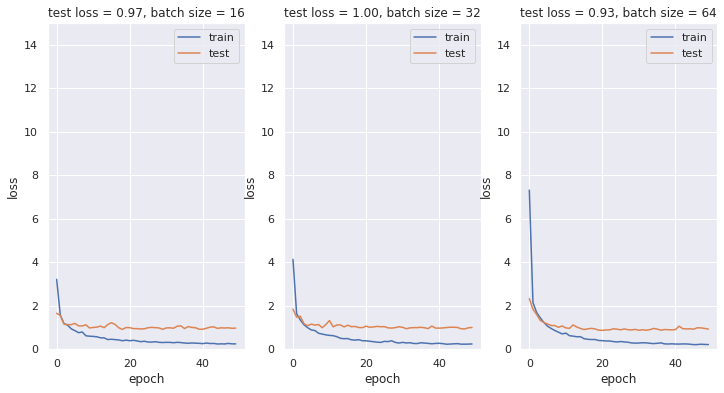

In [78]:

fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)

for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)

    model = neural_network_model(layer1_size,layer2_size, layer3_size)
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=50,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

 ### It's crystal clear from the results that the model trained with a batch size of 64 outperformed the others, boasting the lowest error rate. After meticulous analysis and consideration, we can confidently proclaim that this model is the undisputed champion and, therefore, the optimal choice for our task.





In [79]:
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=64,
    verbose=0,
)


In [80]:
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

22/22 [==============================] - 0s 774us/step
3.84
6.44
7.98
6.74
8.00


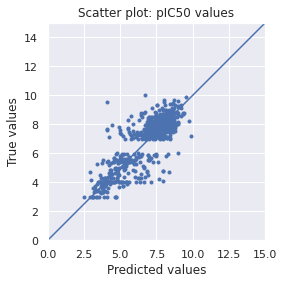

In [81]:
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()


In [82]:
import pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(model)
model.save("network2.h5")

knn_from_pickle = pickle.loads(saved_model)
  
# Use the loaded pickled model to make predictions


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......leaky_re_lu
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-17 13:02:55           64
variables.h5                                   2023-02

In [90]:
chembl_df['canonical_smiles'][3011]

'Cc1nc2c(o1)CN([C@H]1CSC(c3cc(F)ccc3F)[C@@H](N)C1)C2'

In [92]:
chembl_df[3000:3030]

,canonical_smiles,pIC50,fingerprints_df
3000,CC(C)(O)Cn1cc2c(n1)CN([C@H]1CSC(c3cc(F)cc(F)c3...,8.585027,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3001,CS(=O)(=O)n1cc2c(n1)CN([C@H]1CSC(c3cc(F)cc(F)c...,9.301030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3002,CC(C)(F)Cn1cc2c(n1)CN([C@H]1CSC(c3cc(F)cc(F)c3...,8.795880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3003,CS(=O)(=O)n1cc2c(n1)CN([C@H]1CSC(c3cc(F)ccc3F)...,9.221849,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3004,NC(=O)c1[nH]nc2c1CN([C@H]1CSC(c3cc(F)ccc3F)[C@...,9.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3005,N#Cc1[nH]nc2c1CN([C@H]1CSC(c3cc(F)ccc3F)[C@@H]...,9.337242,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3006,N[C@H]1C[C@@H](N2Cc3nc(C(F)(F)F)[nH]c3C2)CSC1c...,8.958607,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3007,N[C@H]1C[C@@H](N2Cc3cnc(C(F)(F)F)nc3C2)CSC1c1c...,9.154902,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3008,N[C@H]1C[C@@H](N2Cc3nc(-c4ccccc4)[nH]c3C2)CSC1...,9.154902,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3009,NC(=O)Cn1cc2c(n1)CN([C@H]1CSC(c3cc(F)cc(F)c3F)...,8.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
